# Run cell mapping: CellTrek

## Imports

In [ ]:
global_path <- './cell-cell-communication/' ## Path to the github downloaded repository

In [2]:
.libPaths('/home/epareja/miniconda3/envs/r4-cellchat/lib/R/library')

library(dior)
library(anndata)
library(dplyr)
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)
library(Seurat)
library(SeuratData)
library(SeuratDisk)
library(reticulate)
library(CellTrek)
library(viridis)
library(ConsensusClusterPlus)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Warning message:
“package ‘SeuratData’ was built under R version 4.2.1”
── Installed datasets ───────────────────────────────────── SeuratData v0.2.2 ──

✔ stxBrain 0.1.1                        


────────────────────────────────────── Key ─────────────────────────────────────

✔ Dataset loaded successfully
❯ Dataset built with a newer version of Seurat than installed
❓ Unknown version of Seurat installed


Warning message:
“package ‘SeuratDisk’ was built under R version 4.2.1”
Registered S3 method

## Load the data

### This is only necessary if you have the data as h5ad (the original publication provides the data in this format)

In [3]:
ad <- import("anndata", convert = FALSE) # you need to have installed anndata 
file_path <- sprintf("%sData/Heart/Global_lognormalised_AVN_AH6.h5ad", global_path)
ad_object <- ad$read_h5ad(file_path)# access normalized data matrix of the specific patient
# access normalized data matrix
data.input <- t(py_to_r(ad_object$X)) # Here you need the genes in the rows
rownames(data.input) <- rownames(py_to_r(ad_object$var))
colnames(data.input) <- rownames(py_to_r(ad_object$obs))
# access meta data
meta.data <- py_to_r(ad_object$obs)
meta <- meta.data

seurat_ref <- CreateSeuratObject(counts = as.data.frame(data.input))
seurat_ref <- RenameCells(seurat_ref, new.names=make.names(Cells(seurat_ref)))
seurat_ref[['cell_names']] <- meta$cell_state


In [9]:
## I convert the h5ad file to .h5 using diopy and now I can read it and create a Seurat object
file_path_spatial <- sprintf("%sData/Heart/adata_sp_AVN_A61.h5", global_path) # path to the spatial data for the specific region
adata = dior::read_h5(file = file_path_spatial,
                assay.name = 'spatial')
adata <- RenameCells(adata, new.names=make.names(Cells(adata)))
adata$orig.ident <- "Visium"




Attaching package: ‘dior’


The following object is masked from ‘package:anndata’:

    read_h5ad




## Run CellTrek

In [ ]:
heart_traint <- CellTrek::traint(st_data=adata, sc_data=seurat_ref, sc_assay='RNA')


Finding transfer anchors... 


No variable features found for object1 in the object.list. Running FindVariableFeatures ...

No variable features found for object2 in the object.list. Running FindVariableFeatures ...



Using 2000 features for integration... 


Running CCA



Merging objects

Finding neighborhoods

Finding anchors

	Found 13503 anchors

Filtering anchors

	Retained 3424 anchors



Data transfering... 


Finding integration vectors

Finding integration vector weights

Transfering 2000 features onto reference data



Creating new Seurat object... 
Scaling -> PCA -> UMAP... 


Centering and scaling data matrix

PC_ 1 
Positive:  ANKRD1, LDB3, MYBPC3, NEBL, MYH6, TECRL, MIR133A1HG, RBM20, TTN, MYOM2 
	   TNNT2, RYR2, TRDN, CHRM2, MLIP, CADPS, FGF12, MYL4, ACTC1, KCNJ3 
	   ACTN2, LINC02248, WNK2, MYOZ2, CMYA5, CACNB2, SORBS2, MYOM1, CTNNA3, RBFOX1 
Negative:  VIM, MGP, C7, GSN, CST3, CFH, DCN, TMSB4X, CFD, FBLN1 
	   FTL, C1R, ADH1B, IFITM3, LRP1, C1S, ZFP36L2, TIMP1, IGFBP7, COL1A2 
	   NEGR1, FBN1, ABCA6, FBLN2, EBF1, SERPING1, TSC22D3, FBLN5, ABCA9, LUM 
PC_ 2 
Positive:  PTPRC, FYB1, DOCK2, IQGAP2, SRGN, SMAP2, SAMSN1, DOCK8, AOAH, PRKCB 
	   CD163, F13A1, MRC1, PIK3R5, CTSB, LYVE1, TBXAS1, MS4A6A, DOCK10, MS4A7 
	   C1QB, RBM47, CYBB, FMN1, TLR2, IKZF1, C1QA, MERTK, CTSS, MSR1 
Negative:  LAMA2, TIMP3, DCN, C7, IGFBP7, FBLN1, CFH, PRKG1, MGP, ABCA8 
	   GSN, COL1A2, BICC1, C1S, C1R, NEGR1, PCDH9, ADH1B, ABI3BP, FBLN2 
	   FBN1, COL6A3, ABCA10, ABCA6, FBLN5, FSTL1, NAV3, LUM, C3, PDGFRA 
PC_ 3 
Positive:  ETS1, EMCN, PPP1R16B, VWF, PITPNC1, FLT1, ST6GALNA

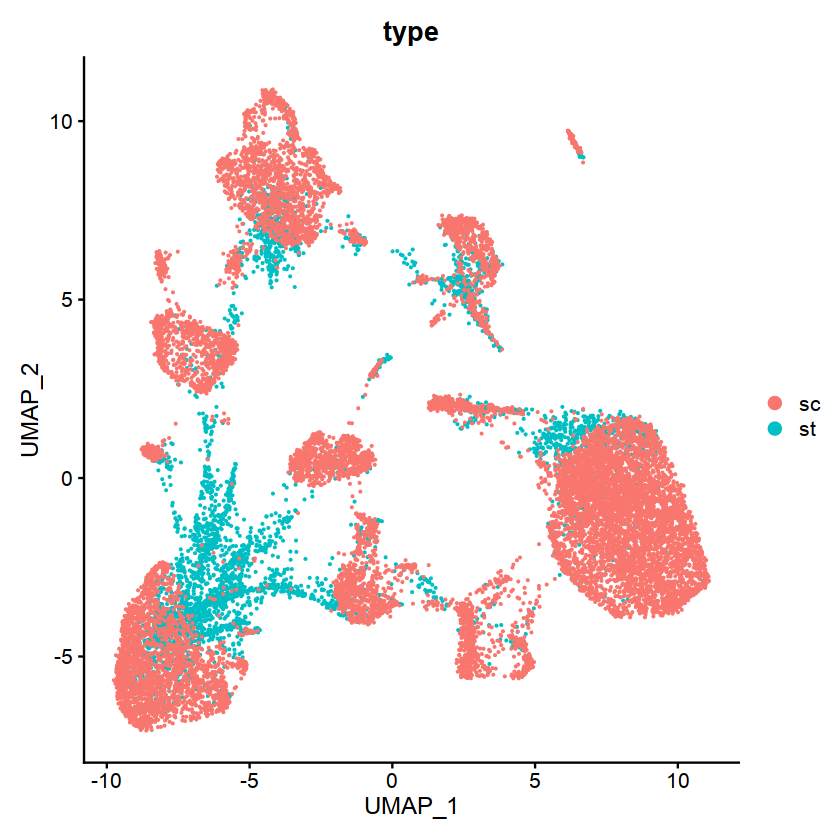

In [ ]:
DimPlot(heart_traint, group.by = "type") 


## Assign cells to spatial location

In [ ]:
heart_celltrek <- CellTrek::celltrek(st_sc_int=heart_traint, int_assay='traint', sc_data=seurat_ref, sc_assay = 'RNA', 
                                   reduction='pca', intp=T, intp_pnt=5000, intp_lin=F, nPCs=30, ntree=1000, 
                                   dist_thresh=0.55, top_spot=1, spot_n=5, repel_r=20, repel_iter=20, keep_model=T)$celltrek

### top_spot to change the number of times a cell can be mapped to a spot   

file_path_result <- sprintf("%sResults/Heart/CellTrek/meta_celltrek_AVN_A61.csv", global_path)
write.csv(heart_celltrek@meta.data, file_path_result, row.names=TRUE)


## Explore cell annotation

In [7]:
CellTrek::celltrek_vis(heart_celltrek@meta.data %>% dplyr::select(coord_x, coord_y, cell_names:id_new),
                       heart_celltrek@images$HCAHeartST11290662@image, heart_celltrek@images$HCAHeartST11290662@scale.factors$lowres)

Loading required package: shiny


Listening on http://127.0.0.1:3327

